In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import keras
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from matplotlib import rcParams
import mlflow

import warnings

warnings.filterwarnings("ignore")

from functions import (
    load_data,
    merge_dataframes,
    plot_loss_accuracy,
    transform_values,
    plot_loss_accuracy,
    Autoencoder, 
    identifying_anomalies,
    plot_values, 
    result_autoencoder
)

In [12]:
# Loading dataframes
df_sensors, df_metadata, df_maintenance, df_failures, df_errors = load_data()

In [13]:
# Extracting base feature list from table
base_features = list(df_sensors.drop(["datetime", "machineID"], axis=1).columns)

In [14]:
# Merging dataframes in one.
df = merge_dataframes(df_sensors, df_failures, df_errors, df_metadata)

In [15]:
time_step = 24

In [16]:
scaler_auto = StandardScaler()
scaler_auto.fit(df[base_features])

StandardScaler()

In [17]:
data_list = []
labels_list = []
for key, data_group in df.groupby("machineID", group_keys=False):
    data, labels = transform_values(data_group, time_step=time_step, scaler=scaler_auto)
    data_list.append(data)
    labels_list.append(labels)
data = np.concatenate(data_list)
labels = np.concatenate(labels_list)

In [18]:
train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

In [19]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

In [20]:
hidden_layers = 3
n_units_latent_space = 16
# epochs = 60
epochs = 2
loss_function = 'mse'

with mlflow.start_run():
    mlflow.keras.autolog()
    callback = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=5)
    keras.utils.set_random_seed(42)
    # autoencoder = Autoencoder(n_layers=3, n_units_latent_space=16)

    # Compiling Model
    autoencoder = Autoencoder(input_shape=data.shape, hidden_layers=hidden_layers, n_units_latent_space=n_units_latent_space)
    autoencoder.compile(optimizer="adam", loss=loss_function, metrics=["accuracy"])
    history = autoencoder.fit(
        train_data,
        train_data,
        epochs=epochs,
        batch_size=512,
        validation_data=(test_data, test_data),
        callbacks=[callback],
    )

Epoch 1/2
1366/1366 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - accuracy: 0.9319 - loss: 0.6562 - val_accuracy: 0.9726 - val_loss: 0.4882
Epoch 2/2
1366/1366 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - accuracy: 0.9728 - loss: 0.4889 - val_accuracy: 0.9739 - val_loss: 0.4882


2024/09/17 12:50:47 WARNING mlflow.keras.autologging: Failed to get model signature, reason: 'Autoencoder' object has no attribute 'output_shape'
2024/09/17 12:50:47 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/09/17 12:50:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [21]:
autoencoder.summary()

Model: "autoencoder_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (None, 24, 16)         │         2,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 24, 5)          │         2,981 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,921 (70.01 KB)

 Trainable params: 5,973 (23.33 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 11,948 (46.68 KB)

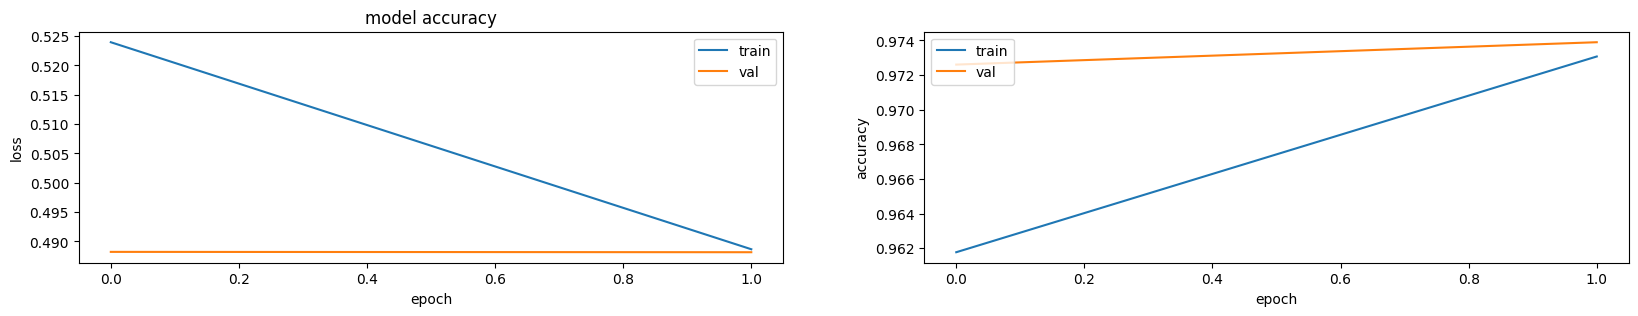

In [22]:
plot_loss_accuracy(history)

In [23]:
mse = result_autoencoder(autoencoder, data)
anomaly_deep_scores = pd.Series(mse.numpy(), name="anomaly_scores")

27318/27318 ━━━━━━━━━━━━━━━━━━━━ 20s 722us/step


In [24]:
threshold = anomaly_deep_scores.quantile(0.965)

In [25]:
index = 0
total_data = []
for key, data_group in df.groupby("machineID", group_keys=False):
    data_group, index = identifying_anomalies(data_group, time_step, index, anomaly_deep_scores)
    total_data.append(data_group)
total_data = pd.concat(total_data)

In [26]:
total_data["pred_anomaly"] = False
total_data.loc[total_data["anomaly_score"] > threshold, "pred_anomaly"] = True

ID: 52


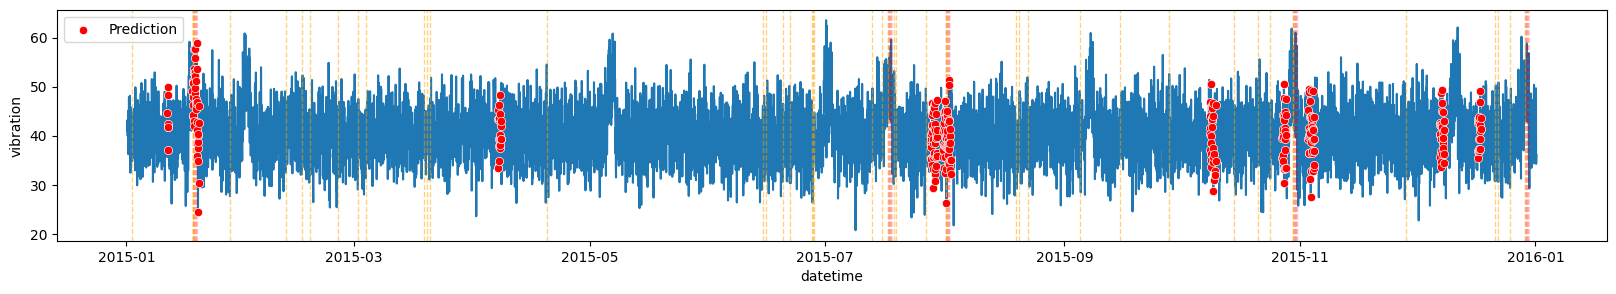

In [27]:
machine_id = np.random.choice(df.machineID.unique())
# machine_id = 10
print("ID:", machine_id)
df_tmp = total_data.query("machineID == @machine_id")
plot_values(df_tmp, base_features=base_features)

In [28]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score


f1 = f1_score(total_data["is_anomaly"], total_data["pred_anomaly"])
print(f"F1 Score (Balance between false positives and true positives): {f1:.2f}")
recall = recall_score(total_data["is_anomaly"], total_data["pred_anomaly"])
print(f"Recall (How well anomalies are detected - True positives): {recall:.2f}")
accuracy = accuracy_score(total_data["is_anomaly"], total_data["pred_anomaly"])
print(f"Accuracy: {accuracy:.2f}")
precision = precision_score(total_data["is_anomaly"], total_data["pred_anomaly"])
print(f"Precision: {precision:.2f}")

F1 Score (Balance between false positives and true positives): 0.27
Recall (How well anomalies are detected - True positives): 0.36
Accuracy: 0.96
Precision: 0.21


In [29]:
total_data["is_real_anomaly"] = ~((total_data["failure"].isnull()))

In [30]:
index = 0
output_data = []
for key, data_group in total_data.groupby("machineID", group_keys=False):
    data_group["is_predicted_anomaly"] = False
    for idx in data_group.query("is_real_anomaly == True").index:
        start_idx = max(0, idx - time_step)  # Index error
        if data_group.loc[start_idx:idx, "pred_anomaly"].sum() > 0:
            data_group.loc[idx, "is_predicted_anomaly"] = True
    output_data.append(data_group)
output_data = pd.concat(output_data)

In [31]:
n_real = output_data.is_real_anomaly.sum()
n_predicted = output_data.is_predicted_anomaly.sum()
print("Number of real anomalies:", n_real)
print("Number of anomalies that were detected:", n_predicted)
print("Percentage of detected anomalies:", round(n_predicted * 100 / n_real, 2))

Number of real anomalies: 761
Number of anomalies that were detected: 414
Percentage of detected anomalies: 54.4


## Saving model

In [32]:
autoencoder.save("../model/autoencoder.keras")

In [36]:
from pickle import dump
dump(scaler_auto, open('../model/scaler.pkl', 'wb'))

In [ ]:
# import mlflow.pyfunc

# model_name = "keras-autoencoder-model-anomaly"
# model_version = 1
# model_tmp = mlflow.pyfunc.load_model(model_uri=f"models:/{model_name}/{model_version}")

In [ ]:
threshold

0.8524960119409963